In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
SP500 = pd.read_csv('../data/SP500.csv') #since 1871
SP500['log_sp500_return'] = np.log(SP500['SP500']) - np.log(SP500['SP500'].shift()) # use log returns
SP500 = SP500[SP500['DATE'] > '1982']

GS1M = pd.read_csv('../data/GS1M.csv') #since 2001-07
GS1M['GS1M'] = (GS1M['GS1M']/100 + 1) ** (1/12) - 1

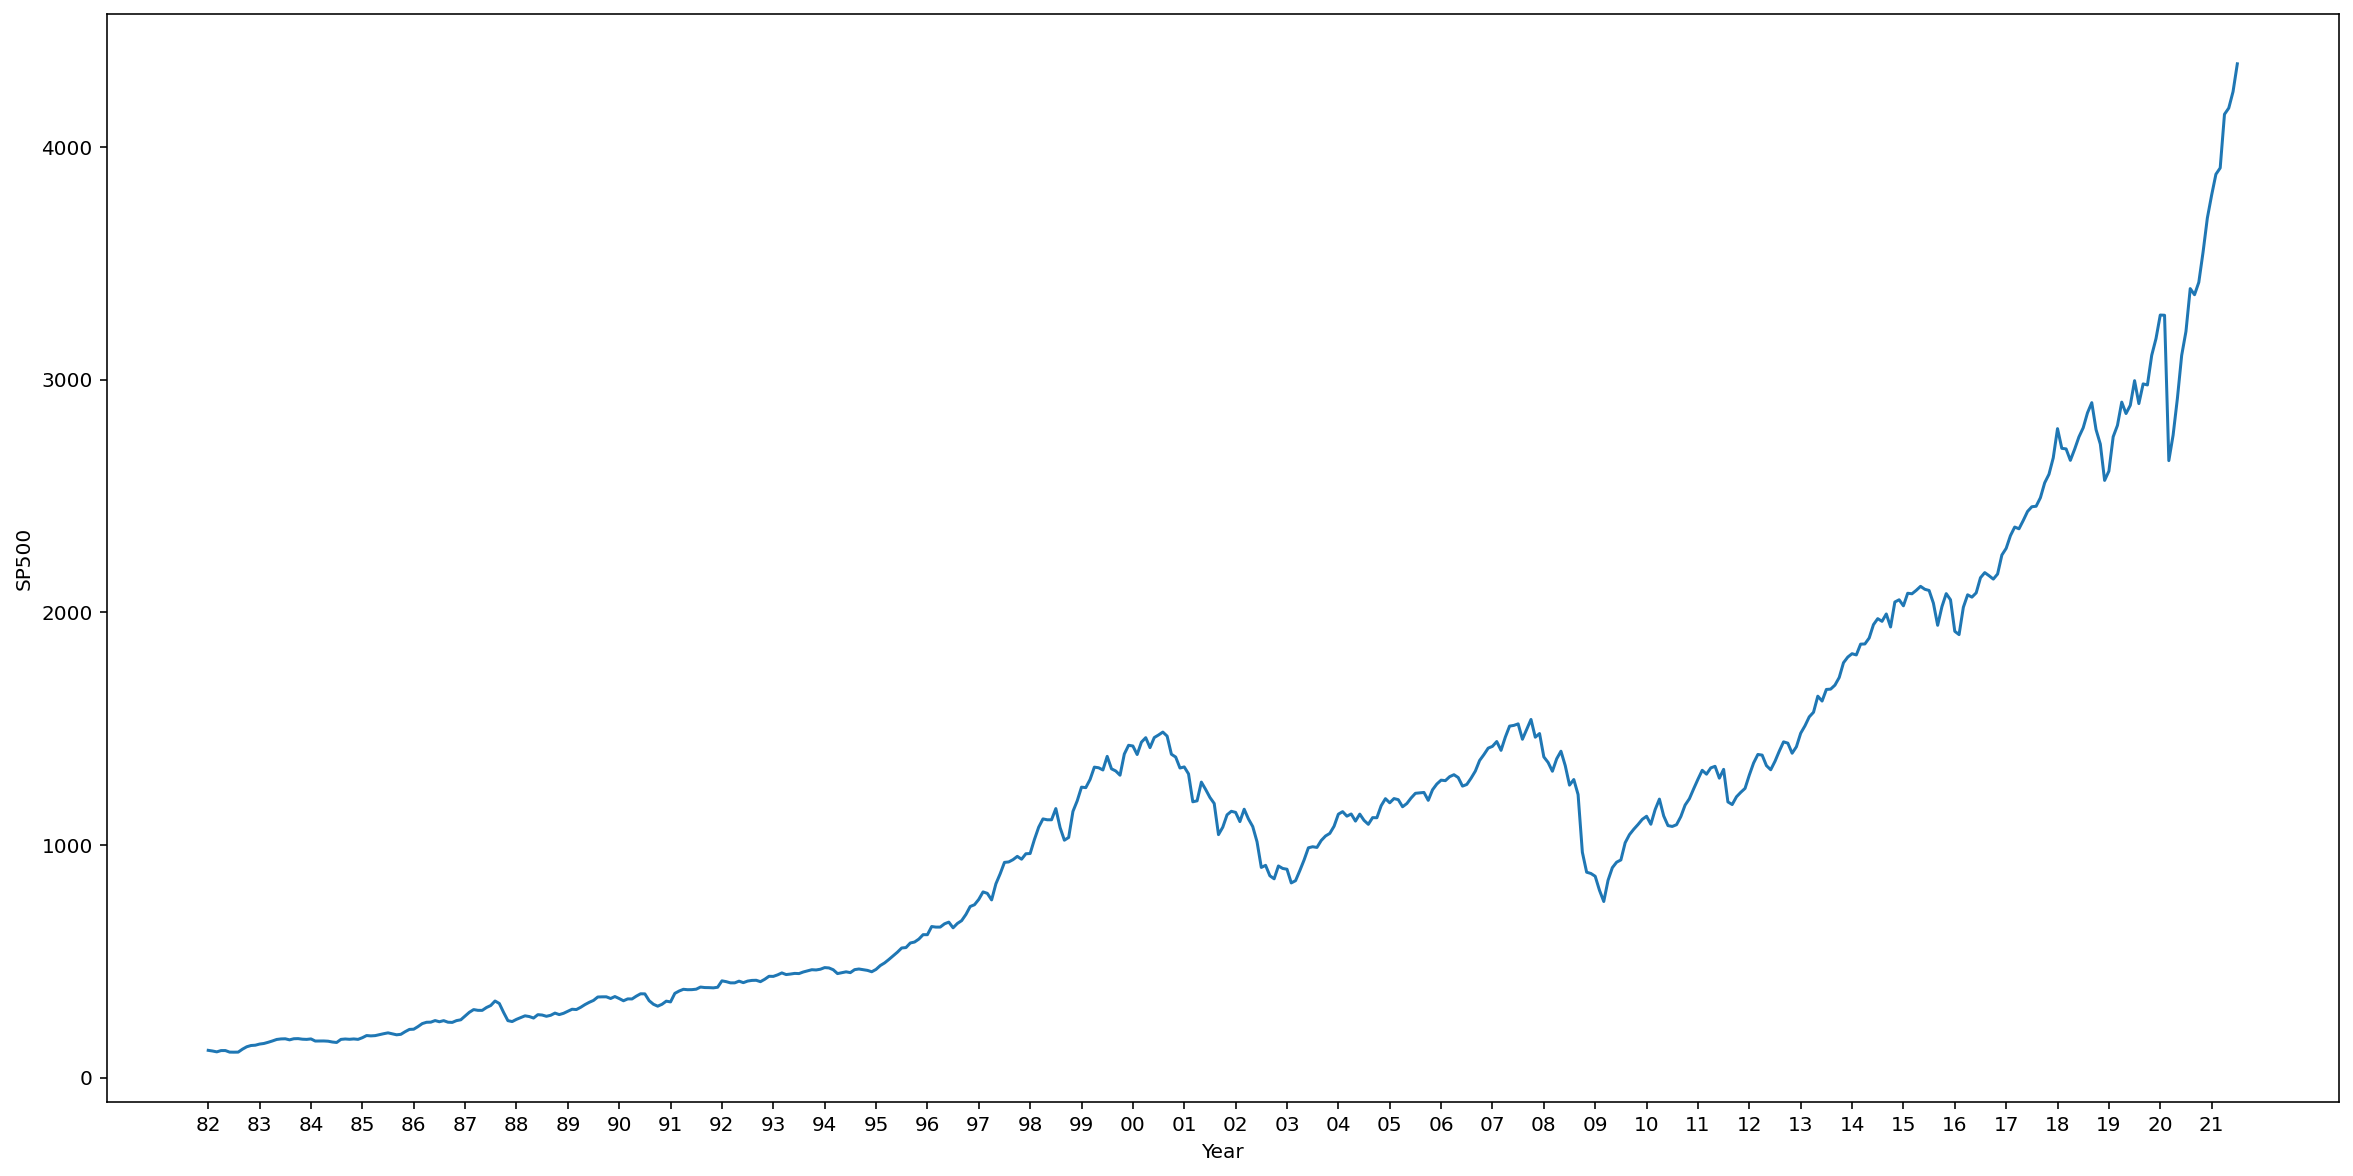

In [3]:
plt.figure(figsize=(20,10))
labels = [_[2:4] for _ in SP500['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(SP500['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('SP500')
plt.plot(SP500['DATE'], SP500['SP500'])

1.575929965838706
2.4737192856248686


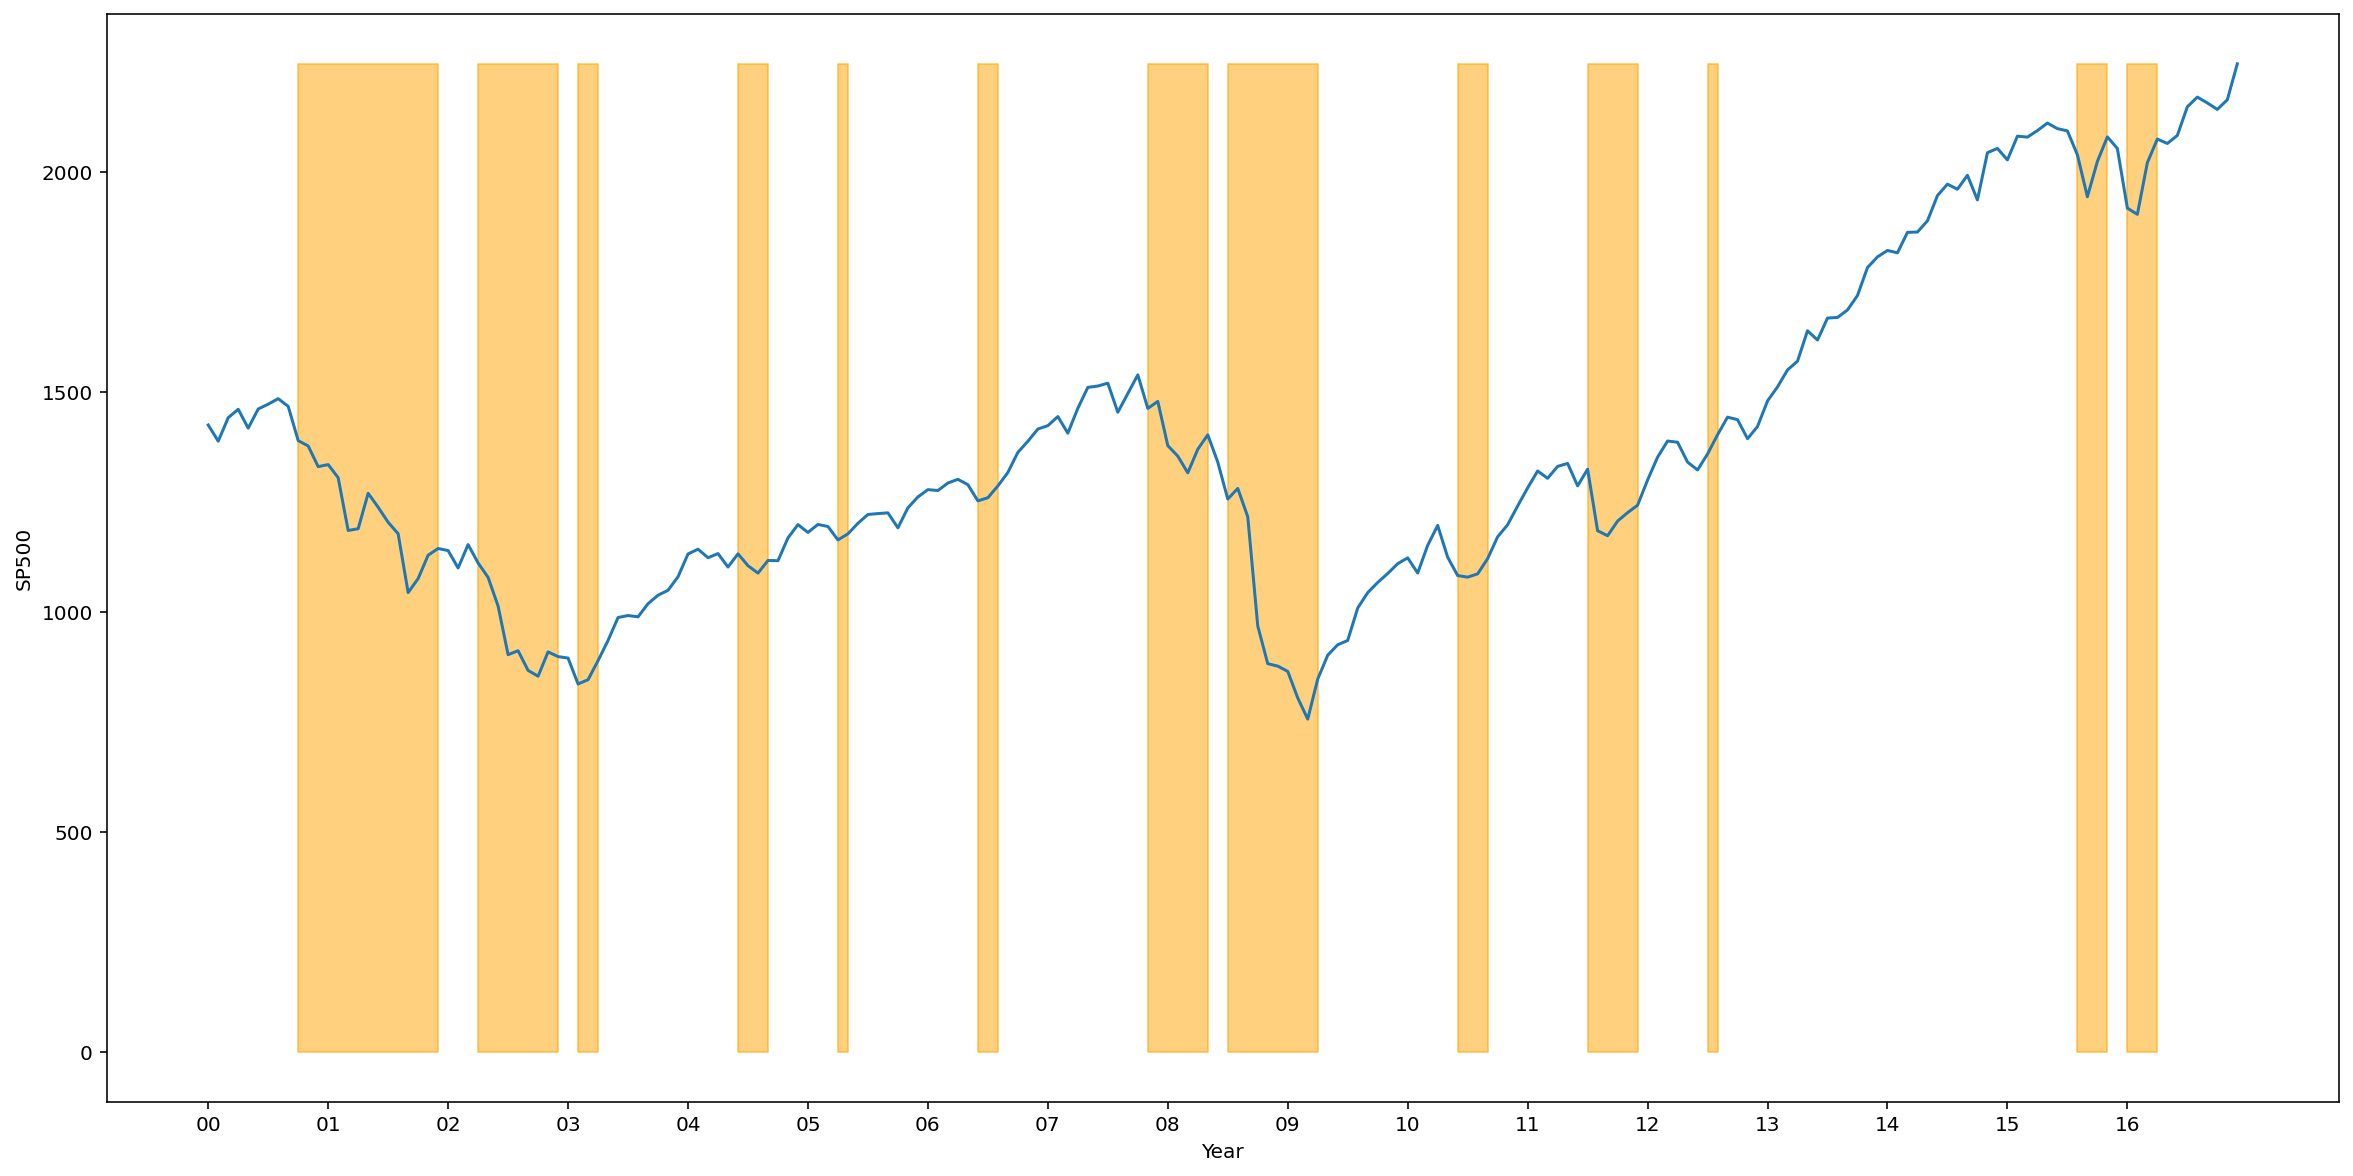

In [4]:
# Single window
demo_df = SP500[('2000' < SP500['DATE']) & (SP500['DATE'] < '2017')]

X = sm.add_constant(demo_df.index)
Y = demo_df['SP500']
rols = RollingOLS(Y, X, window=6)
rres = rols.fit()

res = (rres.params['x1'] < 0) #& (rres.pvalues[:,1] < 0.05)

plt.figure(figsize=(20,10))
labels = [_[2:4] for _ in demo_df['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(demo_df['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('SP500')
plt.plot(demo_df['DATE'], demo_df['SP500'])
plt.fill_between(demo_df['DATE'], np.max(demo_df['SP500']), where=res, color='orange', alpha=0.5)

# Pure S&P holding log return
print(np.exp(np.log(demo_df['SP500'].iloc[-1]) - np.log(demo_df['SP500'].iloc[0])))
# Hold stock only when last month is not bear
hold = ~res.shift(1, fill_value=False)
print(np.exp((demo_df['log_sp500_return'] * hold).sum()))

3.5190252812487004
5.095906393337708
5.095906393337708


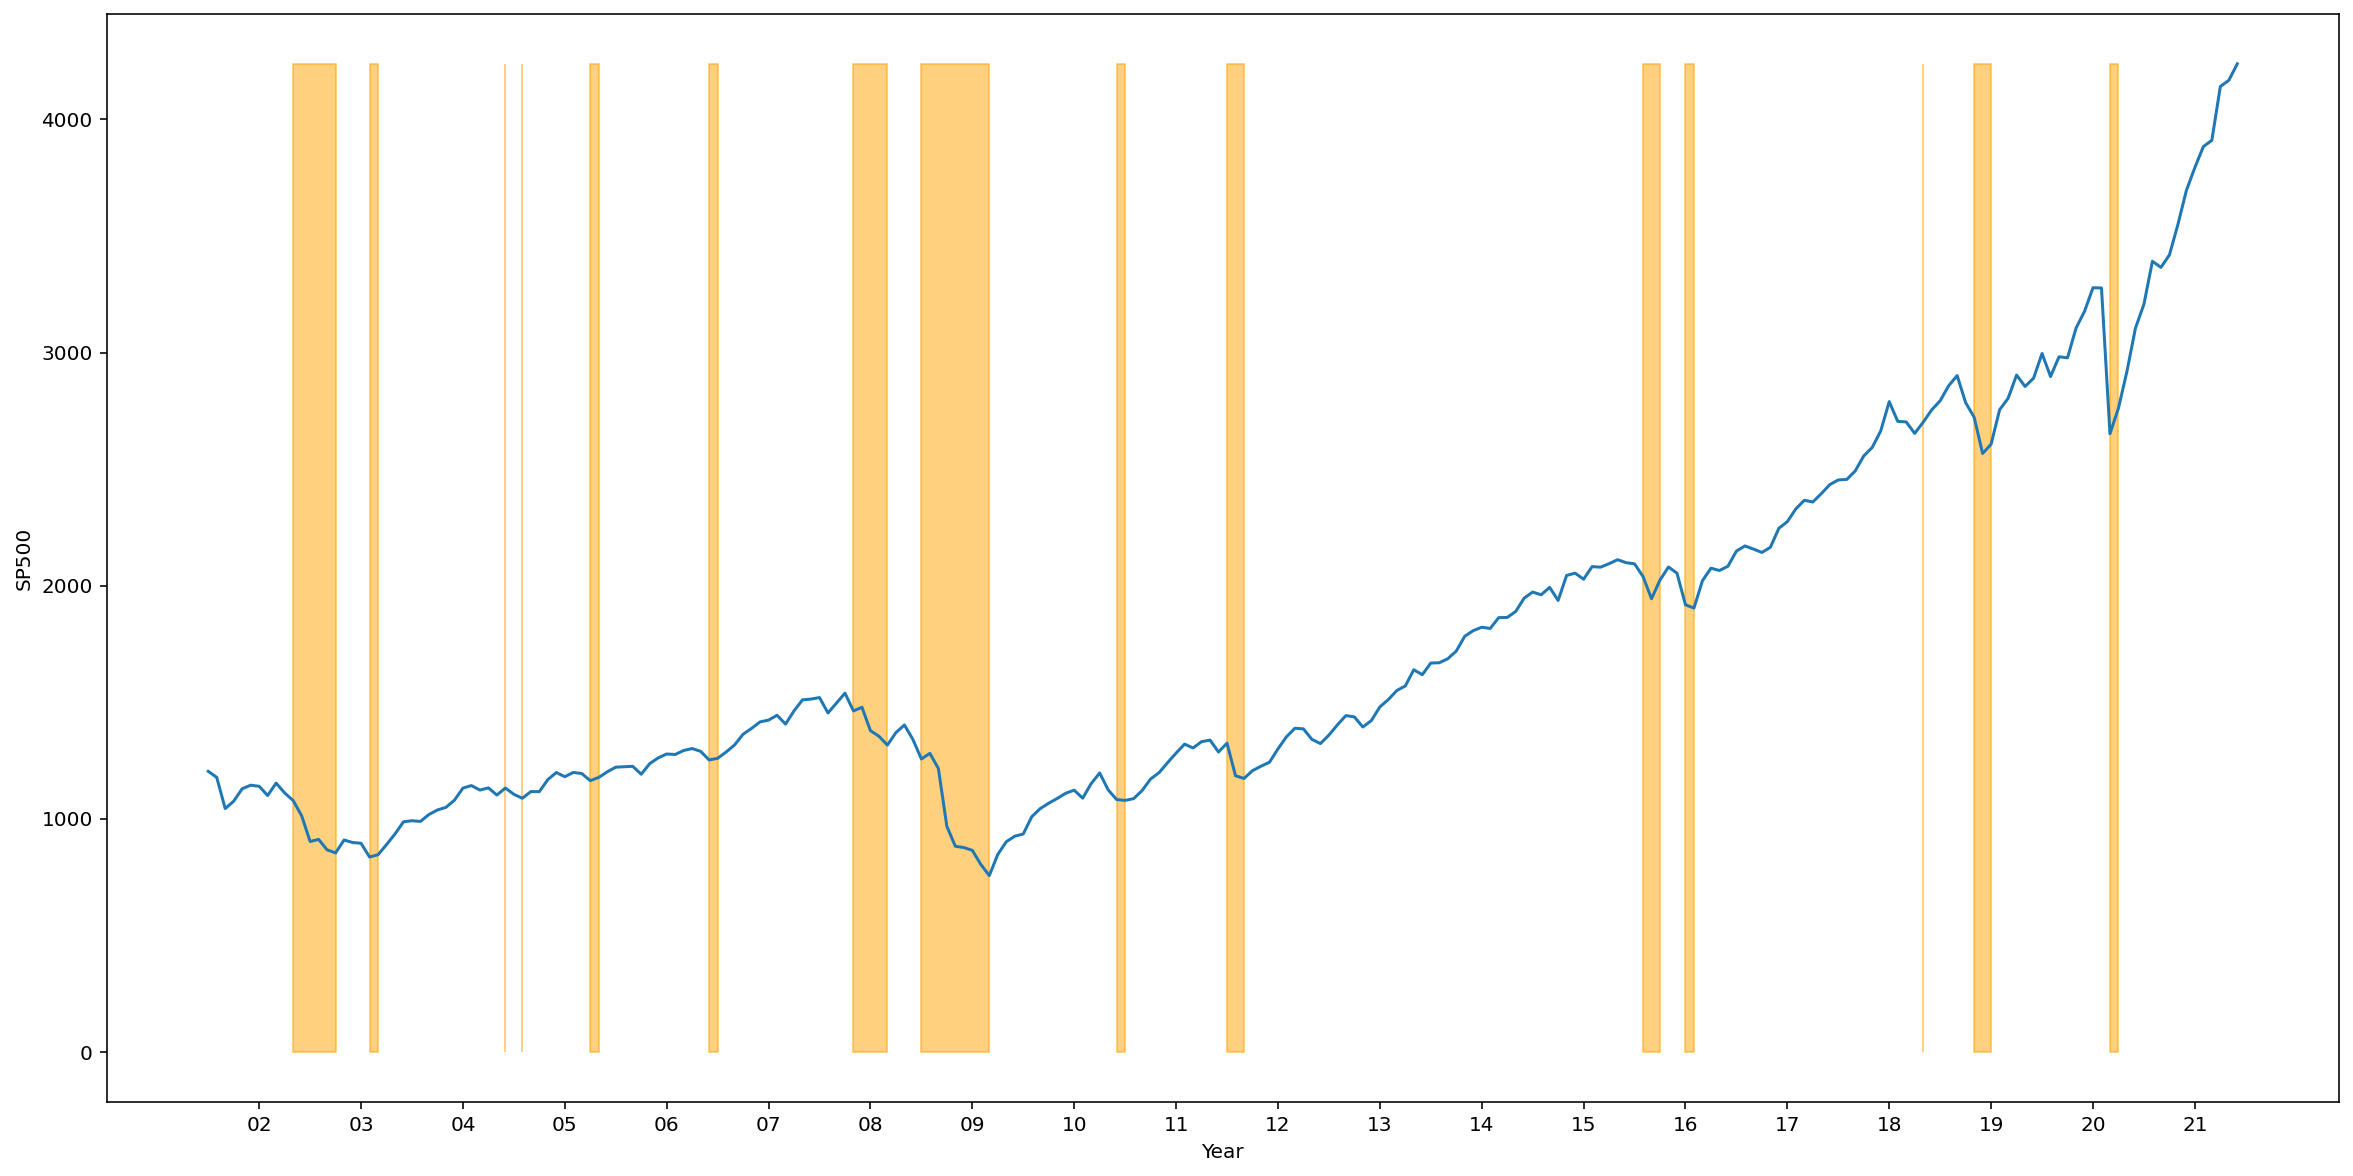

In [11]:
# Duo window
demo_df = SP500[('2001-07-01' <= SP500['DATE']) & (SP500['DATE'] < '2021-07-01')]
demo_df = demo_df.merge(GS1M, on='DATE')
demo_df['log_1m_return'] = np.log(demo_df['GS1M'] + 1)

X = sm.add_constant(demo_df.index)
Y = demo_df['SP500']
rols_1 = RollingOLS(Y, X, window=6)
rres = rols_1.fit()
res_1 = (rres.params['x1'] < 0) #& (rres.pvalues[:,1] < 0.05)

rols_2 = RollingOLS(Y, X, window=3) 
rres = rols_2.fit()
res_2 = (rres.params['x1'] > 0) #& (rres.pvalues[:,1] < 0.05)

res = res_1 & ~res_2 

bear_start = (~res.shift(1, fill_value=False) & res)

all_bears = res.copy()

# for ex post indicator
#for idx in np.where(bear_start)[0]:
#    all_bears.iloc[max(idx-6, 0): idx] = True

plt.figure(figsize=(20,10))
labels = [_[2:4] for _ in demo_df['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(demo_df['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('SP500')
plt.plot(demo_df['DATE'], demo_df['SP500'])
plt.fill_between(demo_df['DATE'], np.max(demo_df['SP500']), where=res, color='orange', alpha=0.5, label="Ex ante bear")
#plt.fill_between(demo_df['DATE'], np.max(demo_df['SP500']), where=all_bears, color='yellow', alpha=0.5, label="Ex post bear")

# Pure S&P holding log return
print(np.exp(np.log(demo_df['SP500'].iloc[-1]) - np.log(demo_df['SP500'].iloc[0])))
# Ex ante
hold = ~res.shift(1, fill_value=False)
print(np.exp((demo_df['log_sp500_return'] * hold).sum()))
# Ex post
hold = ~all_bears.shift(1, fill_value=False)
print(np.exp((demo_df['log_sp500_return'] * hold).sum()))

Portfolio end money 5.095906393337708


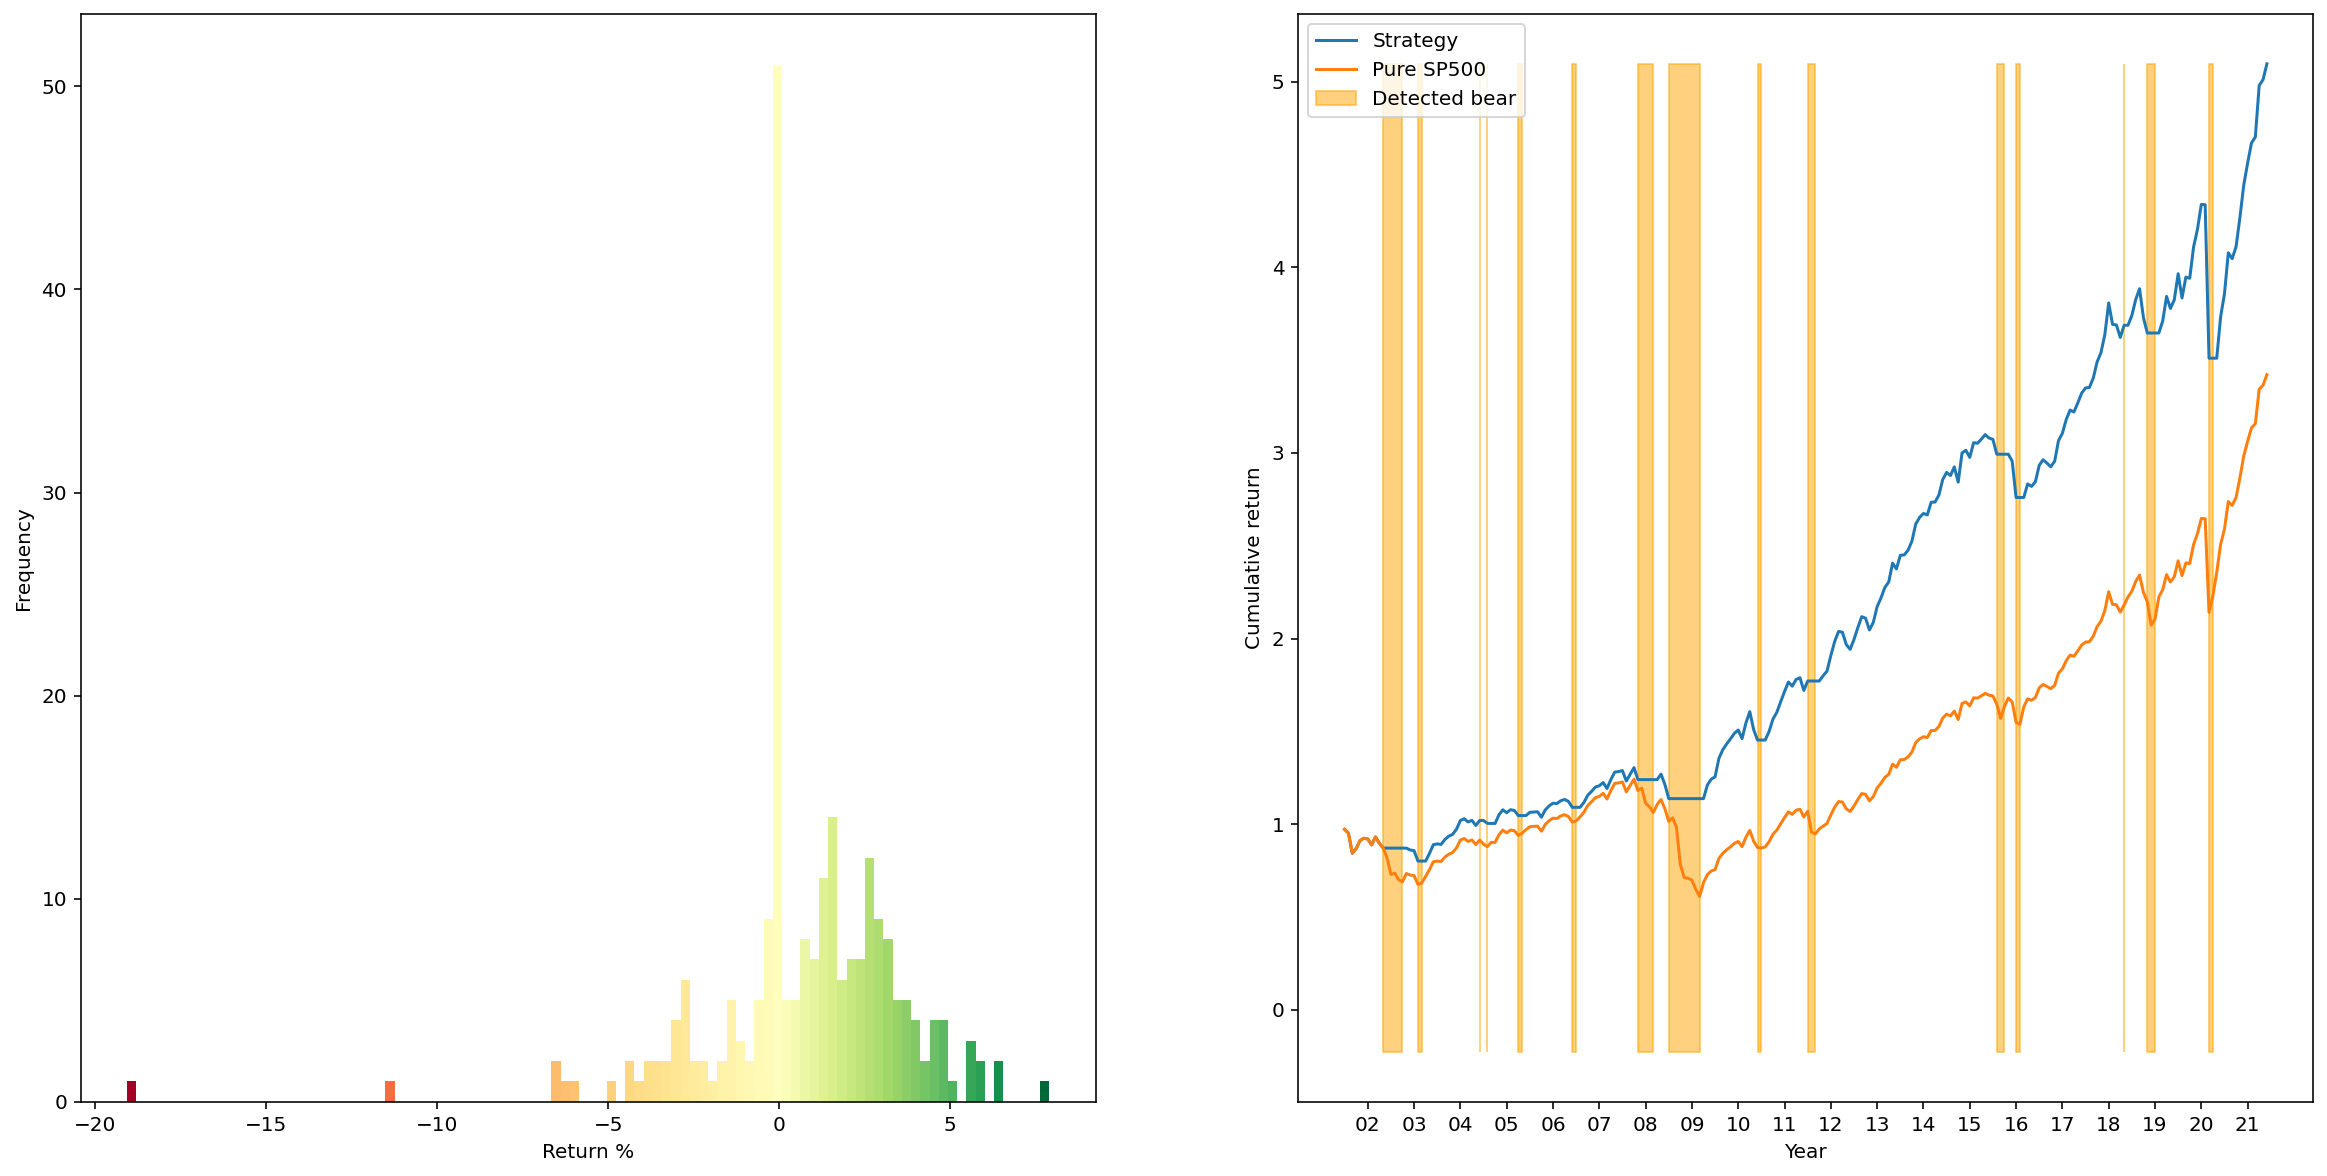

In [6]:
# Cash during bear

hold = ~res.shift(1, fill_value=False)
log_stock_return = demo_df['log_sp500_return'] * hold

portfolio_return = np.exp(log_stock_return) - 1
cumulative_portfolio_return = np.exp(np.cumsum(log_stock_return))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Return %')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(portfolio_return*100, bins=100)

# Color return by colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = (bin_centers / 2 / max(bin_centers)) * (bin_centers > 0) +\
(-bin_centers / 2 / min(bin_centers)) * (bin_centers <= 0) + 0.5
cm = plt.cm.RdYlGn
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.subplot(1,2,2)
labels = [_[2:4] for _ in demo_df['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(demo_df['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('Cumulative return')
plt.plot(demo_df['DATE'], cumulative_portfolio_return, label='Strategy')
plt.plot(demo_df['DATE'], np.exp(np.cumsum(demo_df['log_sp500_return'])), label='Pure SP500')
plt.fill_between(demo_df['DATE'], np.max(cumulative_portfolio_return), np.min(demo_df['log_sp500_return']),
                 where=res, color='orange', alpha=0.5, label="Detected bear")
plt.legend()

print('Portfolio end money', cumulative_portfolio_return.iloc[-1])

Portfolio end money: 	5.328


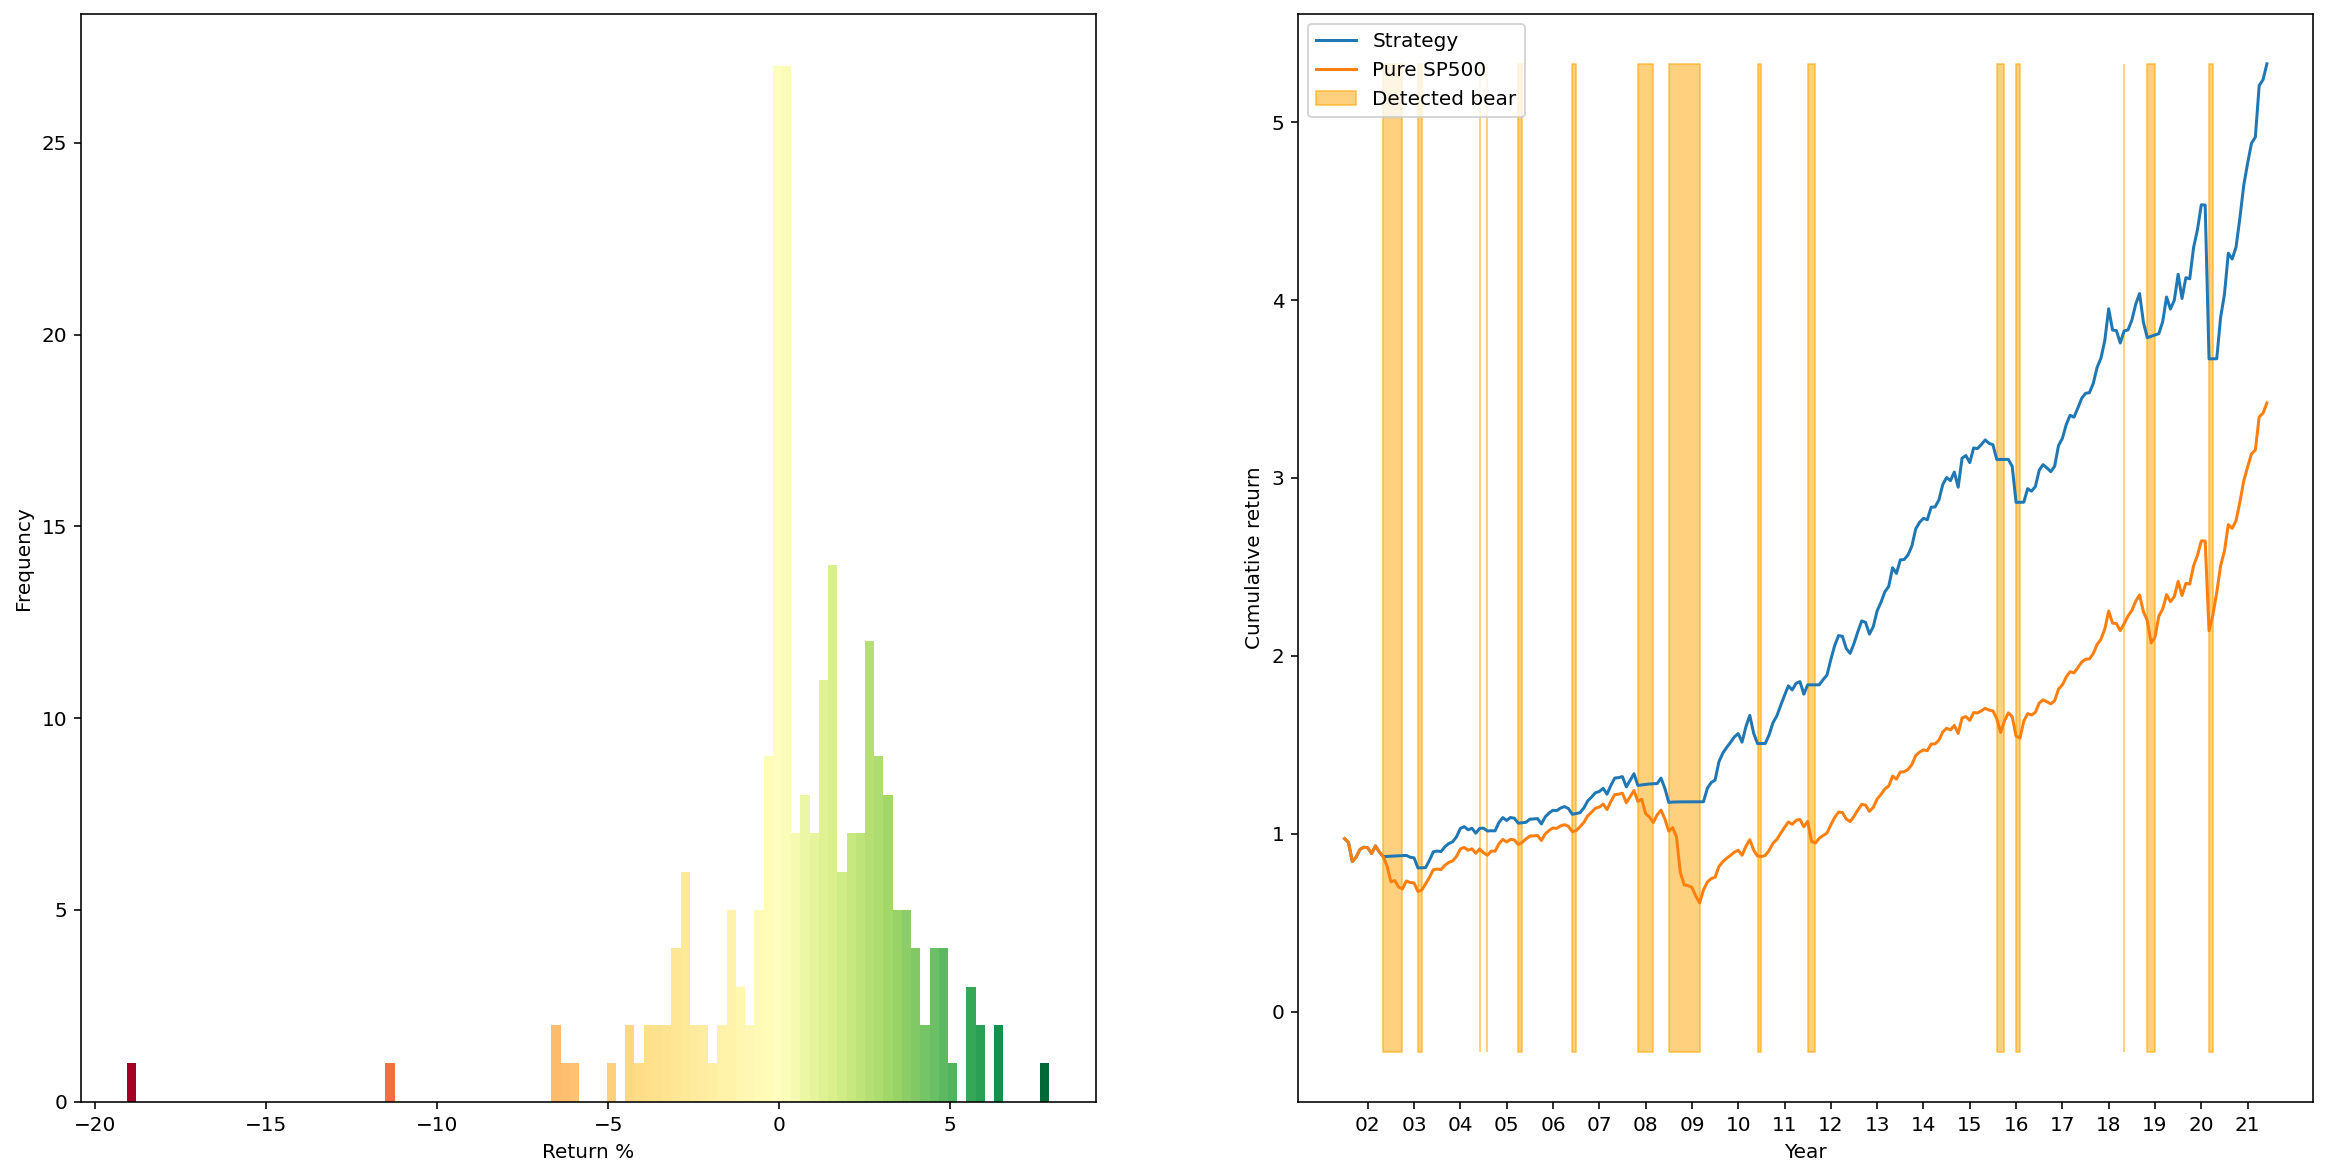

In [7]:
# 1M Treasury Bond during bear
# Using constant maturity because bonds are mostly OTC
# No market price available

hold = ~res.shift(1, fill_value=False)
log_stock_return = demo_df['log_sp500_return'] * hold
log_bond_return = demo_df['log_1m_return'] * ~hold

portfolio_return = np.exp(log_stock_return + log_bond_return) - 1
cumulative_portfolio_return = np.exp(np.cumsum(log_stock_return + log_bond_return))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Return %')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(portfolio_return*100, bins=100)

# Color return by colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = (bin_centers / 2 / max(bin_centers)) * (bin_centers > 0) +\
(-bin_centers / 2 / min(bin_centers)) * (bin_centers <= 0) + 0.5
cm = plt.cm.RdYlGn
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.subplot(1,2,2)
labels = [_[2:4] for _ in demo_df['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(demo_df['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('Cumulative return')
plt.plot(demo_df['DATE'], cumulative_portfolio_return, label='Strategy')
plt.plot(demo_df['DATE'], np.exp(np.cumsum(demo_df['log_sp500_return'])), label='Pure SP500')
plt.fill_between(demo_df['DATE'], np.max(cumulative_portfolio_return),
                 np.min(demo_df['log_sp500_return']), where=res,
                 color='orange', alpha=0.5, label="Detected bear")
plt.legend()

print(f'Portfolio end money: \t{cumulative_portfolio_return.iloc[-1]:.3f}')

In [8]:
# SP500 only

sp500_return = np.exp(demo_df['log_sp500_return']) - 1

R_f = 0.0575 # GS20 monthly
R_p = (sp500_return+1).prod()**(1/20) - 1
σ_p = sp500_return.std() * np.sqrt(12)
sharpe = (R_p-R_f) / σ_p

σ_d = (sum(_**2 for _ in sp500_return if _ < 0) / len(sp500_return)) ** (1/2) * np.sqrt(12)
sortino = (R_p-R_f) / σ_d


print('<SP500>')
print(f'Mean(m): \t\t{sp500_return.mean():.3f}')
print(f'Median(m): \t\t{sp500_return.median():.3f}')
print(f'Standard Deviation(m): \t{sp500_return.std():.3f}')
print(f'Sharpe ratio: \t\t{sharpe:.3f}')
print(f'Sortino ratio: \t\t{sortino:.3f}')


# Portfolio
R_f = 0.0575 # GS20 monthly
R_p = (portfolio_return+1).prod()**(1/20) - 1
σ_p = portfolio_return.std() * np.sqrt(12)
sharpe = (R_p-R_f) / σ_p

σ_d = (sum(_**2 for _ in portfolio_return if _ < 0) / len(portfolio_return)) ** (1/2) * np.sqrt(12)
sortino = (R_p-R_f) / σ_d

print('\n\n<Portfolio>')
print(f'Mean(m): \t\t{portfolio_return.mean():.3f}')
print(f'Median(m): \t\t{portfolio_return.median():.3f}')
print(f'Standard Deviation(m): \t{portfolio_return.std():.3f}')
print(f'Sharpe ratio: \t\t{sharpe:.3f}')
print(f'Sortino ratio: \t\t{sortino:.3f}')

# SP500 as benchmark
R_p = (portfolio_return+1).prod()**(1/20) - 1
R_b = (sp500_return+1).prod()**(1/20) - 1
σ_t = (portfolio_return - sp500_return).std() * np.sqrt(12)

information = (R_p-R_b) / σ_t
print(f'\nInformation ratio: \t{information:.3f}')

<SP500>
Mean(m): 		0.006
Median(m): 		0.013
Standard Deviation(m): 	0.038
Sharpe ratio: 		0.045
Sortino ratio: 		0.060


<Portfolio>
Mean(m): 		0.007
Median(m): 		0.007
Standard Deviation(m): 	0.029
Sharpe ratio: 		0.301
Sortino ratio: 		0.434

Information ratio: 	0.281


In [9]:
monthly_rf = (1+R_f)**(1/12) - 1

market_premium = sp500_return - monthly_rf
X = pd.concat([market_premium.clip(lower=0),
               market_premium.clip(upper=0)],
              axis=1)
X.set_axis(['Upside', 'Downside'], axis=1, inplace=True)

X = sm.add_constant(X)
Y = portfolio_return - monthly_rf
ols = sm.OLS(Y, X)
res = ols.fit()
#res.summary()

print(f'Timing ability: {res.params["Upside"] - res.params["Downside"]:.2f}')
print(f'Selection ability: {res.params["const"]:.2f}')

Timing ability: 0.21
Selection ability: -0.00


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Portfolio end money: 	7.589


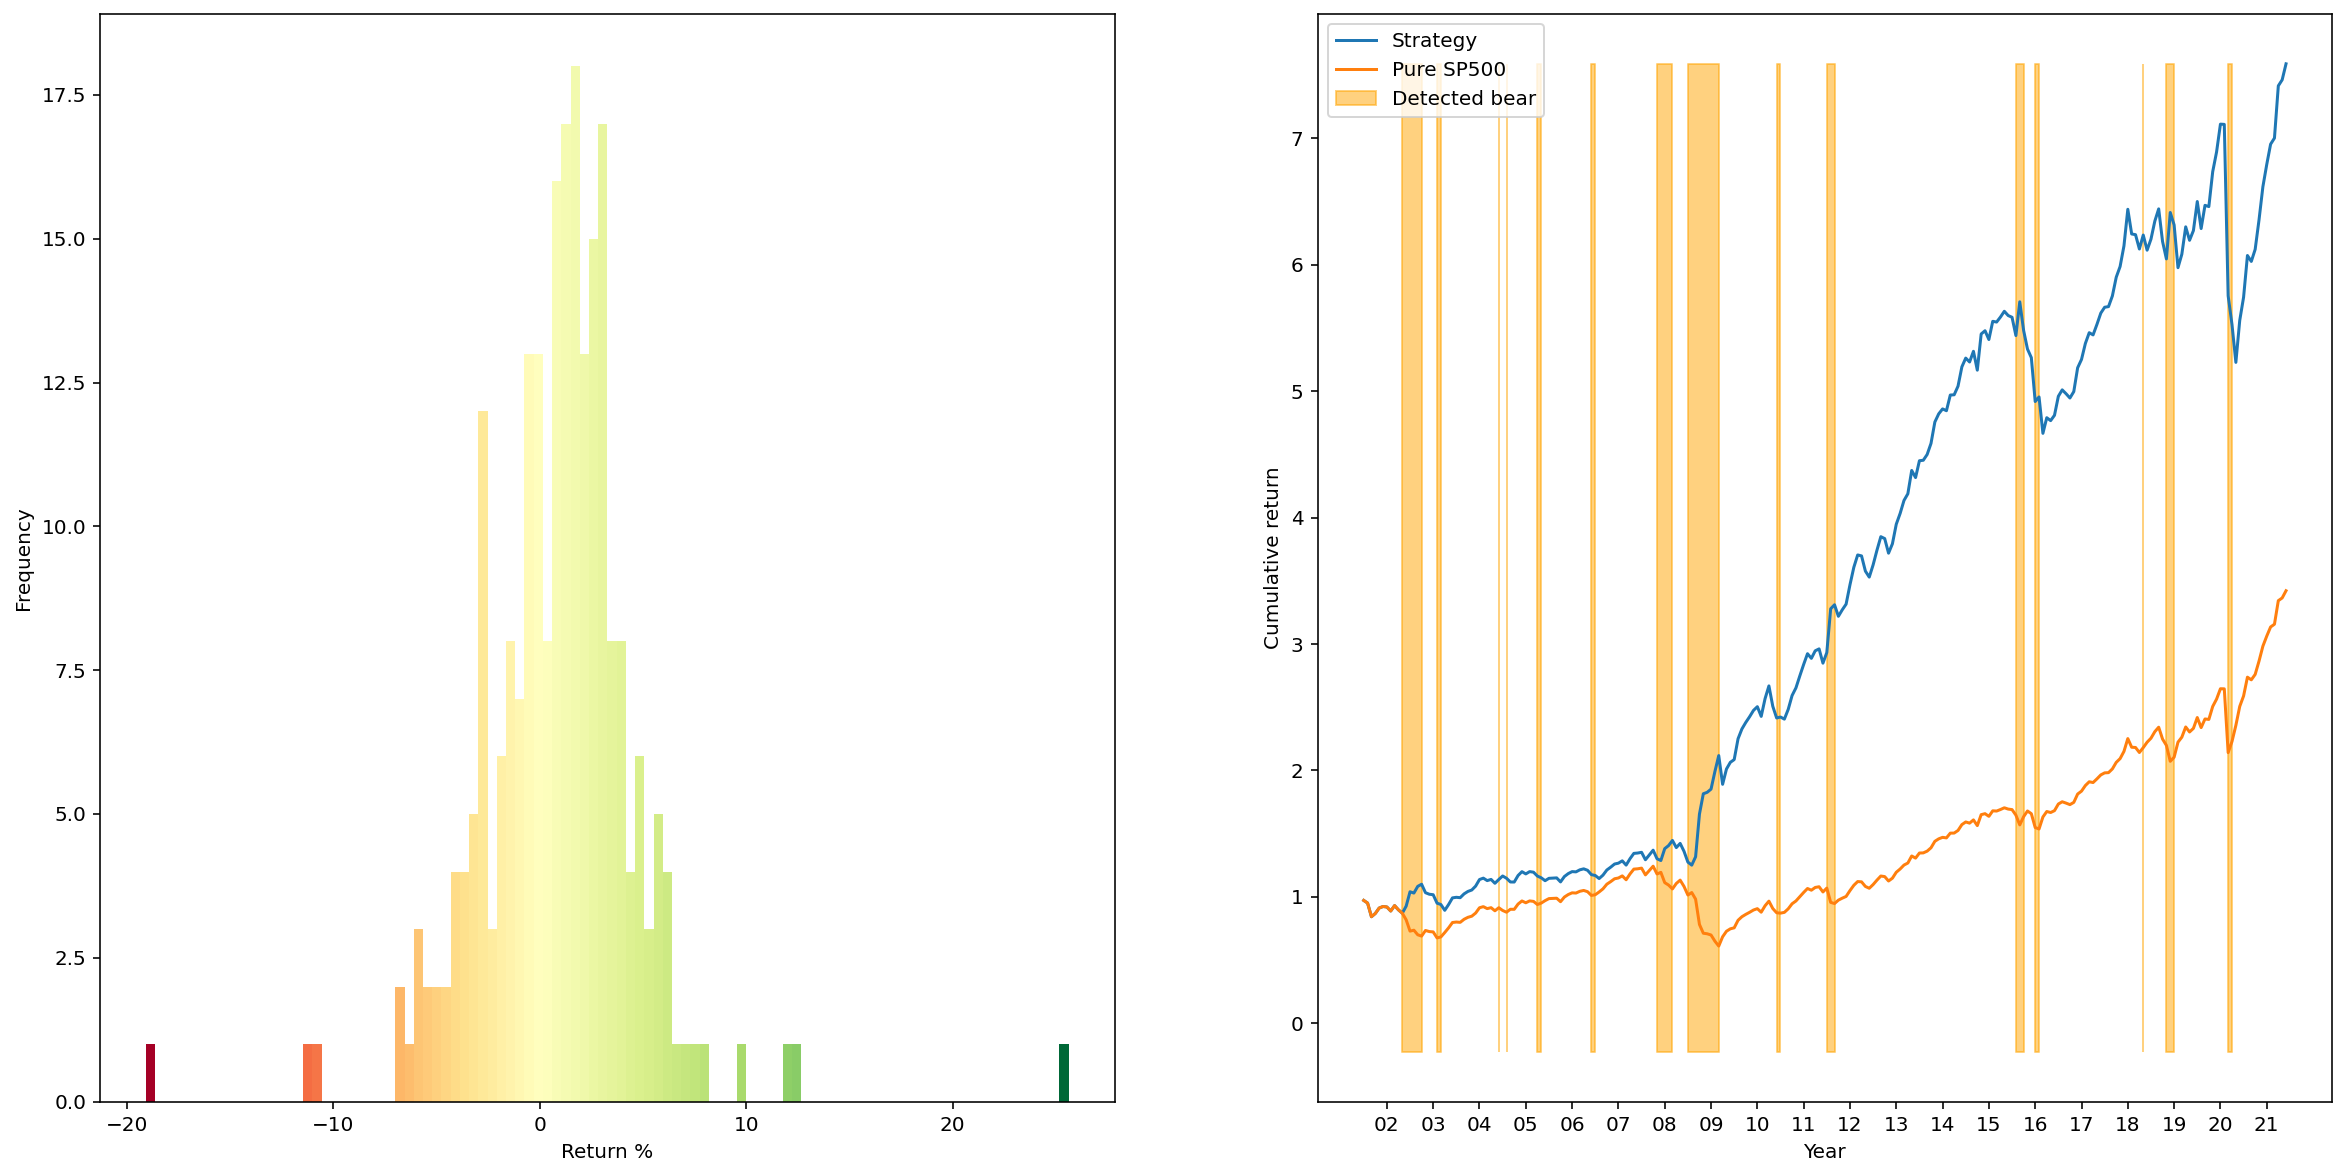

In [12]:
# Short during bear
# Using constant maturity because bonds are mostly OTC
# No market price available

hold = ~res.shift(1, fill_value=False)
log_stock_return = demo_df['log_sp500_return'] * hold
log_bond_return = -demo_df['log_sp500_return'] * ~hold

portfolio_return = np.exp(log_stock_return + log_bond_return) - 1
cumulative_portfolio_return = np.exp(np.cumsum(log_stock_return + log_bond_return))

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Return %')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(portfolio_return*100, bins=100)

# Color return by colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = (bin_centers / 2 / max(bin_centers)) * (bin_centers > 0) +\
(-bin_centers / 2 / min(bin_centers)) * (bin_centers <= 0) + 0.5
cm = plt.cm.RdYlGn
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.subplot(1,2,2)
labels = [_[2:4] for _ in demo_df['DATE'] if _[5:-3] == '01']
ticks = [k for k, v in enumerate(demo_df['DATE']) if v[5:-3] == '01']
plt.xticks(ticks, labels)
plt.xlabel('Year')
plt.ylabel('Cumulative return')
plt.plot(demo_df['DATE'], cumulative_portfolio_return, label='Strategy')
plt.plot(demo_df['DATE'], np.exp(np.cumsum(demo_df['log_sp500_return'])), label='Pure SP500')
plt.fill_between(demo_df['DATE'], np.max(cumulative_portfolio_return),
                 np.min(demo_df['log_sp500_return']), where=res,
                 color='orange', alpha=0.5, label="Detected bear")
plt.legend()

print(f'Portfolio end money: \t{cumulative_portfolio_return.iloc[-1]:.3f}')

In [13]:
# SP500 only

sp500_return = np.exp(demo_df['log_sp500_return']) - 1

R_f = 0.0575 # GS20 monthly
R_p = (sp500_return+1).prod()**(1/20) - 1
σ_p = sp500_return.std() * np.sqrt(12)
sharpe = (R_p-R_f) / σ_p

σ_d = (sum(_**2 for _ in sp500_return if _ < 0) / len(sp500_return)) ** (1/2) * np.sqrt(12)
sortino = (R_p-R_f) / σ_d


print('<SP500>')
print(f'Mean(m): \t\t{sp500_return.mean():.3f}')
print(f'Median(m): \t\t{sp500_return.median():.3f}')
print(f'Standard Deviation(m): \t{sp500_return.std():.3f}')
print(f'Sharpe ratio: \t\t{sharpe:.3f}')
print(f'Sortino ratio: \t\t{sortino:.3f}')


# Portfolio
R_f = 0.0575 # GS20 monthly
R_p = (portfolio_return+1).prod()**(1/20) - 1
σ_p = portfolio_return.std() * np.sqrt(12)
sharpe = (R_p-R_f) / σ_p

σ_d = (sum(_**2 for _ in portfolio_return if _ < 0) / len(portfolio_return)) ** (1/2) * np.sqrt(12)
sortino = (R_p-R_f) / σ_d

print('\n\n<Portfolio>')
print(f'Mean(m): \t\t{portfolio_return.mean():.3f}')
print(f'Median(m): \t\t{portfolio_return.median():.3f}')
print(f'Standard Deviation(m): \t{portfolio_return.std():.3f}')
print(f'Sharpe ratio: \t\t{sharpe:.3f}')
print(f'Sortino ratio: \t\t{sortino:.3f}')

# SP500 as benchmark
R_p = (portfolio_return+1).prod()**(1/20) - 1
R_b = (sp500_return+1).prod()**(1/20) - 1
σ_t = (portfolio_return - sp500_return).std() * np.sqrt(12)

information = (R_p-R_b) / σ_t
print(f'\nInformation ratio: \t{information:.3f}')

<SP500>
Mean(m): 		0.006
Median(m): 		0.013
Standard Deviation(m): 	0.038
Sharpe ratio: 		0.045
Sortino ratio: 		0.060


<Portfolio>
Mean(m): 		0.009
Median(m): 		0.013
Standard Deviation(m): 	0.039
Sharpe ratio: 		0.366
Sortino ratio: 		0.610

Information ratio: 	0.244


1. Bond data
2. distribution of returns on blue line, summary stats(mean, std, …)
3. ratio: Sharpe & Sortino & information ratio
4. Henriksson & Merton
5. Jensen's alpha

* try something else
* ways to implement in reality(transaction cost)
* platform(interactive broker)
* try other instrument(small stocks)
* SMB long small, short big; leverage the size effect
* option strategy
* skip next week

* short
* transaction cost
* CMA